# Figure 4 - bar chart of SWMT in control, up, down, no_katabatics

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import matplotlib.colors as col
import matplotlib.path as mpath
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.gridspec as gs
import cmocean as cm
import matplotlib.patches as mpatches

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/v45/akm157/figures/easterlies/paper_figures/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43319,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:33723,Total threads: 4
Dashboard: /proxy/43457/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:40785,


In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'
easterlies_up_noDSW = '01deg_jra55v13_ryf9091_easterlies_up10_noDSW'

start_time='2155-01-01'
end_time='2159-12-31'

lat_slice  = slice(-80,-50)
lon_slice  = slice(-280, 80)

In [4]:
# topography data:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)

# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90
fontsize=16

# Load prepocessed SWMT:

In [5]:
start_time='2150-01-01'
end_time='2159-12-31'
time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

# stitch together west and east sections:
outpath = '/g/data/v45/akm157/model_data/access-om2/'+control+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_control_west = output.net_transformation_control
outpath = '/g/data/v45/akm157/model_data/access-om2/'+control+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_control_east = output.net_transformation_control
net_transformation_control = xr.concat([net_transformation_control_west,net_transformation_control_east],dim='xt_ocean')

# Note that I forgot to change the names of these variables when I saved them, but despite that they are for the correct simulations:
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_up_west = output.net_transformation_up1
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_up_east = output.net_transformation_up1
net_transformation_up = xr.concat([net_transformation_up_west,net_transformation_up_east],dim='xt_ocean')

outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_down+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_down_west = output.net_transformation_up1
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_down+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_down_east = output.net_transformation_up1
net_transformation_down = xr.concat([net_transformation_down_west,net_transformation_down_east],dim='xt_ocean')

outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up_noDSW+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_up_noDSW_west = output.net_transformation_up1
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up_noDSW+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_up_noDSW_east = output.net_transformation_up1
net_transformation_up_noDSW = xr.concat([net_transformation_up_noDSW_west,net_transformation_up_noDSW_east],dim='xt_ocean')

# Make masks for different regions (use same masks as in Figure 1):


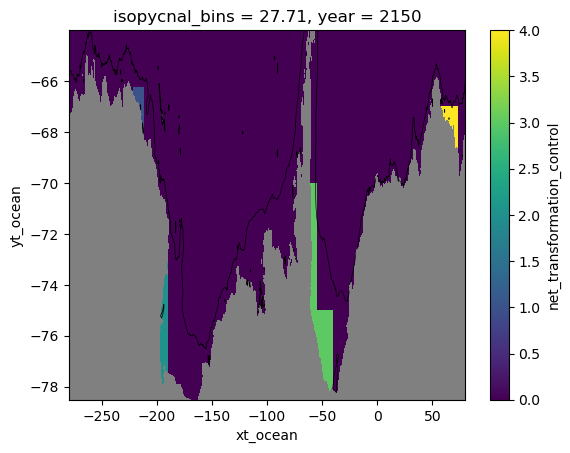

In [6]:
# set up empty masks:
Ross_mask = net_transformation_control[0,0,...]*0+1
Ross_mask = Ross_mask.fillna(1)

Adelie_mask = Ross_mask.copy()
Weddell_mask = Ross_mask.copy()
Prydz_mask = Ross_mask.copy()

yt_ocean = Ross_mask.yt_ocean
xt_ocean = Ross_mask.xt_ocean

# set regions:
Ross_mask = Ross_mask.where(yt_ocean<-72).where(yt_ocean>-79).where(xt_ocean>161.5-360).where(xt_ocean<170-360)

Prydz_mask = Prydz_mask.where(yt_ocean<-67).where(yt_ocean>-69).where(xt_ocean>58).where(xt_ocean<73)

Adelie_mask = Adelie_mask.where(yt_ocean<-66.2).where(yt_ocean>-69).where(xt_ocean>138-360).where(xt_ocean<148-360)

# two area to include for this one:
Weddell_maskW = Weddell_mask.where(yt_ocean<-70).where(yt_ocean>-79).where(xt_ocean>297-360).where(xt_ocean<305-360)
Weddell_maskE = Weddell_mask.where(yt_ocean<-75).where(yt_ocean>-79).where(xt_ocean>305-360).where(xt_ocean<320-360)
Weddell_mask = Weddell_maskE.fillna(0) + Weddell_maskW.fillna(0)
Weddell_mask = Weddell_mask.where(Weddell_mask == 1)

#Weddell_mask.plot()
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],linewidths=0.5,colors='k')
#plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

### note region order:
# regions = ['Adelie','Ross','Weddell','Prydz']

# combine all masks:
combined_mask = Adelie_mask.fillna(0) + Ross_mask.fillna(0)*2 + Weddell_mask.fillna(0)*3 + Prydz_mask.fillna(0)*4

combined_mask.plot()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],linewidths=0.5,colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

In [7]:
## Find density thresholds to use for each region using a 10 year average of the control:

time_slice = slice(2150,2159)
control_transformation_mean = net_transformation_control.sel(year=time_slice).mean('year')

area_t = cc.querying.getvar(control, 'area_t', master_session, n=1)

regions = ['Adelie','Ross','Weddell','Prydz']
density_threshold_low = np.zeros(4)
density_threshold_high = np.zeros(4)

# use density where SWMT is 70% of peak value:
percent_max_SWMT_low = 0.7
percent_max_SWMT_high = 0.3

for DSW_region_count in range(4):
    region = regions[DSW_region_count]
    area_mask = area_t.where(combined_mask == DSW_region_count + 1)
    swmt_sum_region = ((control_transformation_mean*area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6).compute()
    #swmt_sum_region.plot(marker='.',label=region)
    # find max value:
    swmt_max = swmt_sum_region.max().values
    # find density where swmt = 0.7*swmt_max:
    density_threshold_low[DSW_region_count] = swmt_sum_region.where(swmt_sum_region >= swmt_max*percent_max_SWMT_low,drop=True)[-1].isopycnal_bins.values
    density_threshold_high[DSW_region_count] = swmt_sum_region.where(swmt_sum_region <= swmt_max*percent_max_SWMT_high,drop=True)[0].isopycnal_bins.values

In [9]:
# Compute data for bar chart (average between 30-70% of peak CONTROL SWMT):

time_slice = slice(2155,2159)

control_values = np.zeros(4)
up_values = np.zeros(4)
down_values = np.zeros(4)
up_noDSW_values = np.zeros(4)

for DSW_region_count in range(4):

    region = regions[DSW_region_count]
    area_mask = area_t.where(combined_mask == DSW_region_count + 1)
    density_low = density_threshold_low[DSW_region_count]
    density_high = density_threshold_high[DSW_region_count]
    
    # Extract single DSW region, multiply by area and sum over lat/lon, convert to Sv:
    control_values[DSW_region_count] = (net_transformation_control.sel(isopycnal_bins=slice(density_low,density_high))* area_mask).sum(['xt_ocean', 'yt_ocean']).mean('isopycnal_bins').sel(year=time_slice).mean('year')/1e6
    up_values[DSW_region_count] = (net_transformation_up.sel(isopycnal_bins=slice(density_low,density_high))* area_mask).sum(['xt_ocean', 'yt_ocean']).mean('isopycnal_bins').sel(year=time_slice).mean('year')/1e6
    down_values[DSW_region_count] = (net_transformation_down.sel(isopycnal_bins=slice(density_low,density_high))* area_mask).sum(['xt_ocean', 'yt_ocean']).mean('isopycnal_bins').sel(year=time_slice).mean('year')/1e6
    up_noDSW_values[DSW_region_count] = (net_transformation_up_noDSW.sel(isopycnal_bins=slice(density_low,density_high))* area_mask).sum(['xt_ocean', 'yt_ocean']).mean('isopycnal_bins').sel(year=time_slice).mean('year')/1e6  

In [10]:
iso = xr.open_dataset('/g/data/e14/jn8053/misc/Antarctic_isobath_1000m.nc')

In [11]:
ht = ht.sel(yt_ocean = slice(-80, -59)).load()

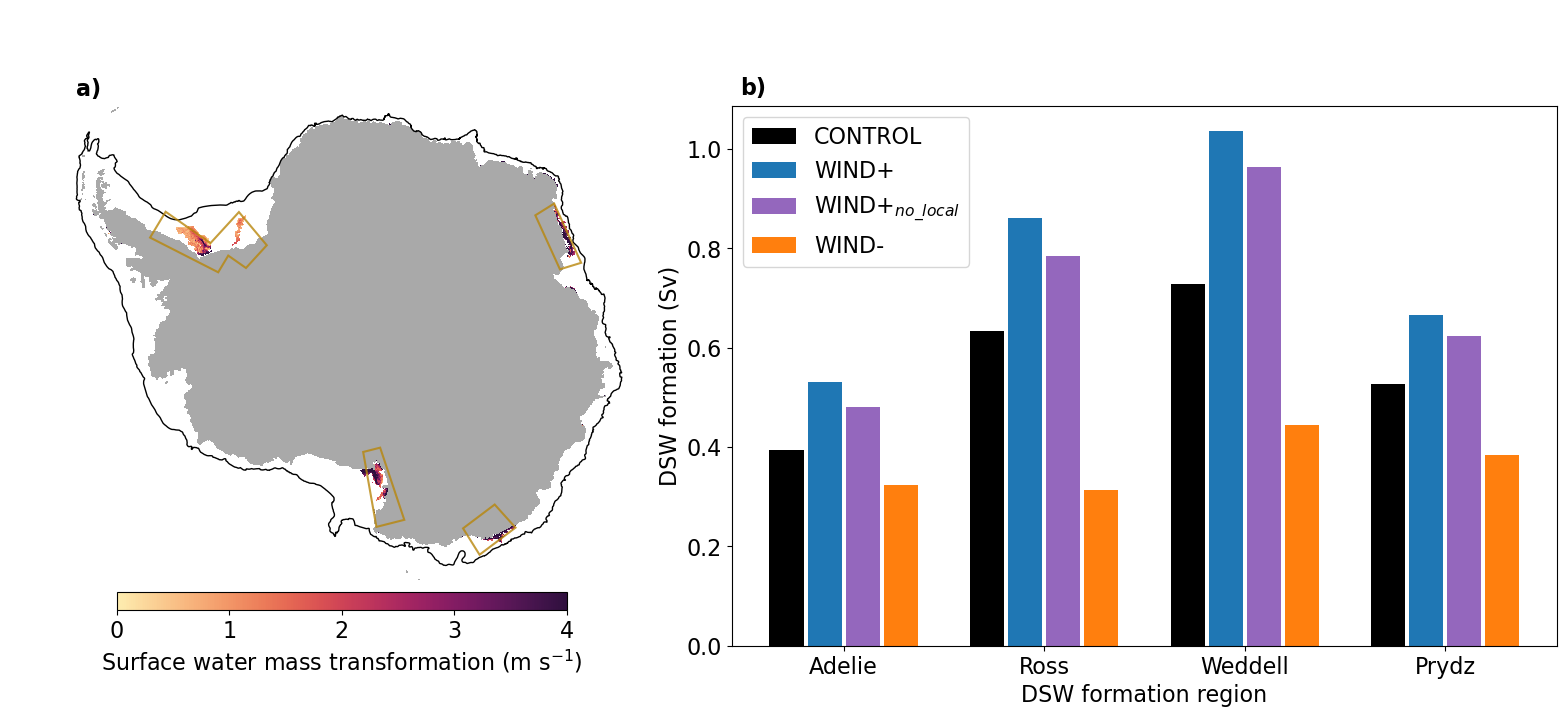

In [64]:
# DSW regions:

poly1 = mpatches.Polygon(np.transpose(np.array([[161.5-360,170-360,170-360,161.5-360,161.5-360],[-79,-79,-72,-72,-79]])), closed = True, ec = 'darkgoldenrod', 
                        fill = False, lw = 1.5, fc = 'goldenrod', alpha = 0.8, zorder = 2, transform=ccrs.PlateCarree())
poly2 = mpatches.Polygon(np.transpose(np.array([[58,73,73,58,58],[-69,-69,-67,-67,-69]])), closed = True, ec = 'darkgoldenrod', 
                        fill = False, lw = 1.5, fc = 'goldenrod', alpha = 0.8, zorder = 2, transform=ccrs.PlateCarree())
poly3 = mpatches.Polygon(np.transpose(np.array([[138-360,148-360,148-360,138-360,138-360],[-69,-69,-66.2,-66.2,-69]])), closed = True, ec = 'darkgoldenrod', 
                        fill = False, lw = 1.5, fc = 'goldenrod', alpha = 0.8, zorder = 2, transform=ccrs.PlateCarree())
poly4 = mpatches.Polygon(np.transpose(np.array([[297-360,305-360,305-360,320-360,320-360,305-360,305-360,297-360,297-360],[-70,-70,-75,-75,-79,-79,-77,-77,-70]])), closed = True, ec = 'darkgoldenrod', 
                        fill = False, lw = 1.5, fc = 'goldenrod', alpha = 0.8, zorder = 2, transform=ccrs.PlateCarree())

plt.rcParams['font.size'] = 16
fig = plt.figure(1,figsize = (15, 6))

# SWMT map
ax1 = fig.add_axes([-.35,.03,1.1,1.1], projection = ccrs.SouthPolarStereo())
ax1.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())
ax1.text(0.1, .87, 'a)', transform=ax1.transAxes, size = 16, weight='bold')
ax1.axis("off")
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90
ax1.contourf(ht['xt_ocean'], land_mask_lat, xr.where(np.isnan(ht), 1, np.nan), 
                colors = 'darkgrey', linewidths = 0.5, 
                zorder = 2,transform = ccrs.PlateCarree())
ax1.plot(iso['x'], iso['y'], 'k', linewidth = 1, zorder = 2,transform = ccrs.PlateCarree())
# Adelie
ax1.pcolormesh(net_transformation_control['xt_ocean'], net_transformation_control['yt_ocean'],
               (net_transformation_control).where(xt_ocean <=-205).sel(isopycnal_bins = (density_threshold_low[0]+density_threshold_high[0])/2.,method='nearest').mean('year')*1e5,
               vmin = 0, vmax = 4, cmap = cm.cm.matter,transform = ccrs.PlateCarree())
# Ross
ax1.pcolormesh(net_transformation_control['xt_ocean'], net_transformation_control['yt_ocean'],
               (net_transformation_control).where((xt_ocean >-210) & (xt_ocean<-100)).sel(isopycnal_bins = (density_threshold_low[1]+density_threshold_high[1])/2.,method='nearest').mean('year')*1e5,
               vmin = 0, vmax = 4, cmap = cm.cm.matter,transform = ccrs.PlateCarree())
# Weddell
ax1.pcolormesh(net_transformation_control['xt_ocean'], net_transformation_control['yt_ocean'],
               (net_transformation_control).where((xt_ocean <0) & (xt_ocean>-100)).sel(isopycnal_bins = (density_threshold_low[2]+density_threshold_high[2])/2.,method='nearest').mean('year')*1e5,
               vmin = 0, vmax = 4, cmap = cm.cm.matter,transform = ccrs.PlateCarree())
# Prydz
c = ax1.pcolormesh(net_transformation_control['xt_ocean'], net_transformation_control['yt_ocean'],
                   (net_transformation_control).where((xt_ocean>0)).sel(isopycnal_bins = (density_threshold_low[3]+density_threshold_high[3])/2.,method='nearest').mean('year')*1e5,
                   vmin = 0, vmax = 4, cmap = cm.cm.matter,transform = ccrs.PlateCarree())
cax = fig.add_axes([0.05,0.13,0.3,0.03])
plt.colorbar(c, cax = cax, orientation = 'horizontal').set_label('Surface water mass transformation (m s$^{-1}$)', fontsize = 16)
# Masked DSW regions
ax1.add_patch(poly1)
ax1.add_patch(poly2)
ax1.add_patch(poly3)
ax1.add_patch(poly4)

ax2 = fig.add_axes([0.46,0.07,0.55,.9])
x = np.arange(len(regions))  # the label locations
width = 0.17  # the width of the bars
rects1 = ax2.bar(x - 3/2*width-.03, control_values, width, color = 'k', label = 'CONTROL')
rects2 = ax2.bar(x - width/2-.01, up_values, width, color = 'C0', label = 'WIND+')
rects3 = ax2.bar(x + width/2+.01, up_noDSW_values, width, color = 'C4', label = r'WIND+$_{no\_local}$')
rects4 = ax2.bar(x + 3/2*width+.03, down_values, width, color = 'C1', label = 'WIND-')

ax2.text(0.01, 1.02, 'b)', transform=ax2.transAxes, size = 16, weight='bold')
ax2.set_ylabel('DSW formation (Sv)')
ax2.set_xlabel('DSW formation region')
ax2.set_xticks(x)
ax2.set_xticklabels(regions)
ax2.legend(fontsize = fontsize, loc = 2)
plt.savefig('Figure-4.jpg', bbox_inches = 'tight')